In [1]:
# sets the backend of matplotlib to the 'inline' backend:
# With this backend, the output of plotting commands is displayed inline within frontends 
# like the Jupyter notebook, directly below the code cell that produced it.

%matplotlib inline 

This tutorial is adapted from the pytorch [beginner tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html). Feel free to check out other available tutorials if you think you benefit from it!


Build a Neural Network
===================

Neural networks comprise of layers/modules that perform operations on data.
The [`torch.nn`](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to
build your own neural network. Every module in PyTorch subclasses the [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.


In [2]:
import os
import torch
from torch import nn

Get Device for Training
-----------------------
We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[`torch.cuda`](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the CPU.



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Except if you have a cuda driver correctly installed the device in use should be "cpu". Later in the course you will need to work with GPU power so lets switch to google colab where free GPU is available. Execute the cell above again in google colab. Keep in mind that imports have not yet been executed in the colab environment!

Define the Network Class
-------------------------
We define our neural network by subclassing ``nn.Module``, and
initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.



In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.



In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)




To use the model, we pass it the input data. This executes the model's ``forward``,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call ``model.forward()`` directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class.
We get the prediction probabilities by passing it through an instance of the ``nn.Softmax`` module.



In [6]:
X = torch.rand(1, 28, 28, device=device)  # random tensor
logits = model(X)  # forward
pred_probab = nn.Softmax(dim=1)(logits)  # predicted probability for all classes
y_pred = pred_probab.argmax(1)  # predicted probability for max class
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


--------------




Model Layers
-------------------------

Let's break down the layers in the NeuralNetwork model. To illustrate it, we
will take a sample minibatch of 3 images of size 28x28 and see what happens to it as
we pass it through the network.



In [7]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten


We initialize the [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained).



In [8]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

The [`linear layer`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its stored weights and biases.




In [9]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our
linear layers, but there's other activations to introduce non-linearity in your model.



In [10]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.1164,  0.3738, -0.0132,  0.1139, -0.9814,  0.1526, -0.4781, -0.1578,
         -0.3161,  0.3852, -0.0955,  0.0505, -0.0678,  0.1836,  0.3640,  0.0552,
          0.1291,  0.1889,  0.1535, -0.1237],
        [ 0.3068,  0.3626,  0.3630, -0.0866, -0.8257,  0.3692, -0.1242, -0.0092,
          0.0695,  0.2260,  0.2021, -0.1438,  0.2249, -0.1812,  0.3892,  0.0401,
          0.1500,  0.1900, -0.1248, -0.3112],
        [ 0.2249,  0.2919,  0.3052,  0.4195, -0.6052,  0.1030, -0.1671, -0.0443,
         -0.4138,  0.6158,  0.1827, -0.1795,  0.1126, -0.0261,  0.3051, -0.1185,
          0.1720,  0.3123,  0.3938, -0.4658]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.1164, 0.3738, 0.0000, 0.1139, 0.0000, 0.1526, 0.0000, 0.0000, 0.0000,
         0.3852, 0.0000, 0.0505, 0.0000, 0.1836, 0.3640, 0.0552, 0.1291, 0.1889,
         0.1535, 0.0000],
        [0.3068, 0.3626, 0.3630, 0.0000, 0.0000, 0.3692, 0.0000, 0.0000, 0.0695,
         0.2260, 0.2021, 0.0000, 0.2249, 0.0000, 0.38

### nn.Sequential

[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like ``seq_modules``.



In [11]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

print(logits)

tensor([[-0.1864,  0.2035,  0.0393,  0.0367,  0.1981,  0.0259, -0.1089,  0.0641,
          0.1717,  0.1522],
        [-0.2406,  0.1357,  0.0377, -0.0170,  0.1773,  0.1343, -0.0737, -0.0654,
          0.1175,  0.2538],
        [-0.3234,  0.1562,  0.1608,  0.1717,  0.2804,  0.2513, -0.1030, -0.1725,
         -0.0105,  0.3073]], grad_fn=<AddmmBackward0>)


### nn.Softmax

The last linear layer of the neural network returns `logits` - raw values in `[-infty, infty]` - which are passed to the
[`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values
[0, 1] representing the model's predicted probabilities for each class. ``dim`` parameter indicates the dimension along
which the values must sum to 1.



In [12]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

print(pred_probab)

tensor([[0.0776, 0.1146, 0.0973, 0.0970, 0.1140, 0.0960, 0.0839, 0.0997, 0.1110,
         0.1089],
        [0.0744, 0.1084, 0.0982, 0.0930, 0.1130, 0.1082, 0.0879, 0.0886, 0.1064,
         0.1219],
        [0.0661, 0.1067, 0.1072, 0.1084, 0.1208, 0.1173, 0.0823, 0.0768, 0.0903,
         0.1241]], grad_fn=<SoftmaxBackward0>)


Model Parameters
-------------------------
Many layers inside a neural network are *parameterized*, i.e. have associated weights
and biases that are optimized during training. Subclassing ``nn.Module`` automatically
tracks all fields defined inside your model object, and makes all parameters
accessible using your model's ``parameters()`` or ``named_parameters()`` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.




In [13]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0121,  0.0041, -0.0298,  ...,  0.0147, -0.0250, -0.0183],
        [ 0.0069, -0.0236,  0.0281,  ...,  0.0212,  0.0066,  0.0083]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0061, 0.0120], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0071, -0.0022, -0.0386,  ..., -0.0212, -0.0318, -0.0080],
        [-0.0267,  0.0267, -0.0171,  ...,  0.0300,  0.0329,  0.0399]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si

--------------




Load Data
===========================

To do something with your model we actually need a task. So let's get some data. Convieniently, some datasets are available in the torchvision library. We will load them using the DataLoader class from [`torch.utils.data`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#). 

In [14]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [15]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

--------------


Optimizing Model Parameters
===========================

Now that we have a model and data it's time to train, validate and test our model by optimizing its parameters on
our data. Training a model is an iterative process; in each iteration (called an *epoch*) the model makes a guess about the output, calculates the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters, and **optimizes** these parameters using gradient descent.

Hyperparameters
-----------------

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) about hyperparameter tuning if you like)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.



In [16]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Optimization Loop
-----------------

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

### Loss Function


When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [17]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.



In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.


Full Implementation
-----------------------
We define ``train_loop`` that loops over our optimization code, and ``test_loop`` that
evaluates the model's performance against our test data.


In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.290766  [    0/60000]
loss: 2.286922  [ 6400/60000]
loss: 2.271526  [12800/60000]
loss: 2.264180  [19200/60000]
loss: 2.250502  [25600/60000]
loss: 2.215572  [32000/60000]
loss: 2.219085  [38400/60000]
loss: 2.180056  [44800/60000]
loss: 2.180419  [51200/60000]
loss: 2.148534  [57600/60000]
Test Error: 
 Accuracy: 45.9%, Avg loss: 2.144918 

Epoch 2
-------------------------------
loss: 2.151230  [    0/60000]
loss: 2.142177  [ 6400/60000]
loss: 2.092154  [12800/60000]
loss: 2.100654  [19200/60000]
loss: 2.049251  [25600/60000]
loss: 1.991969  [32000/60000]
loss: 2.005038  [38400/60000]
loss: 1.928112  [44800/60000]
loss: 1.936601  [51200/60000]
loss: 1.856895  [57600/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.861011 

Epoch 3
-------------------------------
loss: 1.891505  [    0/60000]
loss: 1.857284  [ 6400/60000]
loss: 1.752995  [12800/60000]
loss: 1.785443  [19200/60000]
loss: 1.675676  [25600/60000]
loss: 1.640156  [32000/600

Curious on how much faster training on a GPU is vs. training on a CPU?

Try running the notebook on a different device!



--------------




Network Visualization
-----------------------


Looking at your architecture and checking all intermediate dimensions can be quite helpful. Look at the following visualization. Can you recognize all the parts of the network?

In [21]:
from torchviz.dot import make_dot

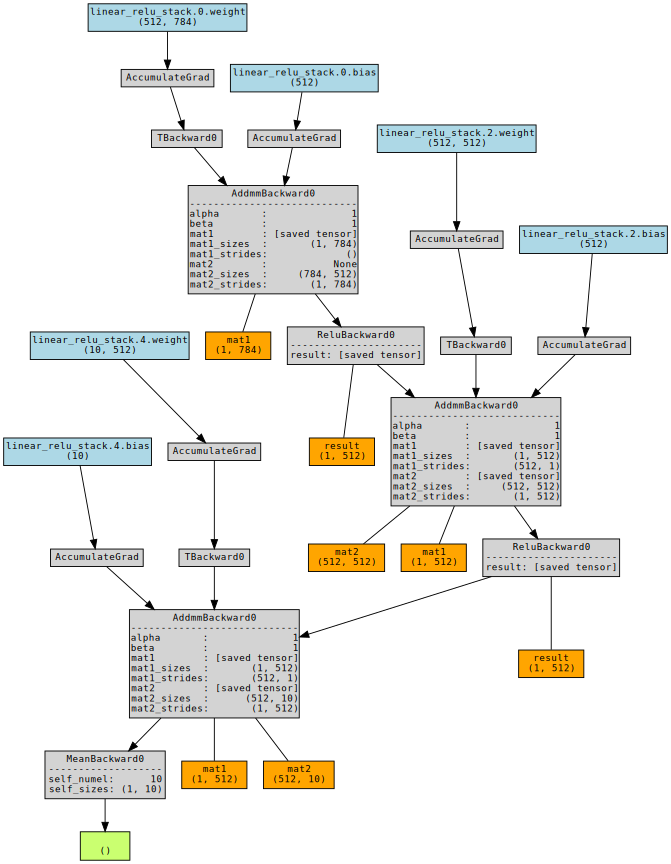

In [22]:
x = torch.randn(1, 1, 28, 28).requires_grad_(False)
outputs = model(x)  # model forward

make_dot(outputs.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

So far - that's it for now. In the course you will dig deeper into the material and learn the details of the topics from above. So don't worry if there are things you don't yet fully understand!